Faces, cats and Dogs.

Nome: Gustavo Cavalcante Oliveira

Matrícula: 130009920

* Mudar os valores das variáveis abaixo de acordo com a sua máquina.

In [1]:
import sys
import os

home_dir = os.getenv("HOME")
caffe_root = os.path.join(home_dir, 'caffe')  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, os.path.join(caffe_root, 'python'))

time_start


Faça download dos seguintes arquivos:

https://github.com/gutioliveira/Algorithms/raw/master/Random/cats.txt

https://github.com/gutioliveira/Algorithms/raw/master/Random/dogs.txt

e salve-os em:

'data/ilsvrc12' dentro do diretório caffe_root.

mesmo diretório do arquivo synset_words.txt.

In [40]:
import time

def print_time(name, time_end, time_start):
    print ('######################')
    print('    time -> method = ' + name )
    print (time_end - time_start)
    print ('######################')

In [39]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import requests
from StringIO import StringIO
import urllib

print caffe_root

import caffe

time_start = time.time()

if os.path.isfile(caffe_root + '/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'

caffe.set_mode_cpu()

model_def = os.path.join(caffe_root, 'models', 'bvlc_reference_caffenet','deploy.prototxt')
model_weights = os.path.join(caffe_root, 'models','bvlc_reference_caffenet','bvlc_reference_caffenet.caffemodel')

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)

mu = np.load(os.path.join(caffe_root, 'python','caffe','imagenet','ilsvrc_2012_mean.npy'))
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

time_end = time.time()

print_time('caffe setup',time_end, time_start)

/home/gustavo/caffe
CaffeNet found.
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
######################
    time -> method = caffe setup
0.599810838699
######################


In [26]:
def detect(frame):
    
    time_start = time.time()
    
    height, width, depth = frame.shape

    # create grayscale version
    grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 
    # equalize histogram
    cv2.equalizeHist(grayscale, grayscale)

    # detect objects
    classifier = cv2.CascadeClassifier(caffe_root + "/haarcascade_frontalface_alt.xml")

    # print classifier

    coords = []

    DOWNSCALE = 4
    minisize = (frame.shape[1]/DOWNSCALE,frame.shape[0]/DOWNSCALE)
    miniframe = cv2.resize(frame, minisize)
    faces = classifier.detectMultiScale(miniframe)
    if len(faces)>0:
        for i in faces:
            x, y, w, h = [ v*DOWNSCALE for v in i ]

            coords.append((x,y,w,h))
            print x,y,w,h
            cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0))
    
    print(str(len(faces)) + ' faces detected.')
    print 'coords: '
    for coord in coords:
    	x,y,w,h = coord
    	print [(x,y), (x+w,y+h), (x+w, y), (x, y+h)]
    	print '\n'
        
    time_end = time.time()
    
    print_time('detect',time_end, time_start)

    return frame

In [41]:
def get_image_url(url):
    
    time_start = time.time()
    
    cap = cv2.VideoCapture(url)
    ret,img = cap.read()
    
    time_end = time.time()
    
    print_time('get_image_url',time_end, time_start)
    
    return img

In [29]:
def get_image_camera():
    
    time_start = time.time()

    cap = cv2.VideoCapture(0)

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()
        img = frame.copy()
        # Call the function
        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()#cv2.destroyAllWindows()
            cv2.destroyAllWindows()
            break

    cv2.imwrite("frame.jpg", frame)
    cv2.imwrite(os.path.join(caffe_root, 'examples', 'images','frame.jpg'), frame)
    
    time_end = time.time()
    
    print_time('get_image_camera', time_end, time_start)

    return frame

In [32]:
def probability(image):
    
    time_start = time.time()
    
    transformed_image = transformer.preprocess('data', image)
    plt.imshow(image)
    plt.axis('off')

    # copy the image data into the memory allocated for the net
    net.blobs['data'].data[...] = transformed_image

    ### perform classification
    output = net.forward()

    output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

    labels_file = os.path.join(caffe_root, 'data','ilsvrc12','synset_words.txt')

    labels = np.loadtxt(labels_file, str, delimiter='\t')

    dogs_file = os.path.join(caffe_root, 'data','ilsvrc12','dogs.txt')
    cats_file = os.path.join(caffe_root, 'data', 'ilsvrc12','cats.txt')

    labels_dogs = np.loadtxt(dogs_file, str, delimiter='\t')
    labels_cats = np.loadtxt(cats_file, str, delimiter='\t')

    top_inds = output_prob.argsort()[::-1][:]

    index = 0

    list_dogs = []
    probability_dogs = 0.0

    for i in labels:
        if i in labels_dogs:
            list_dogs.append((output_prob[index],labels[index]))
            probability_dogs += output_prob[index]
        index += 1

    index = 0

    list_cats = []
    probability_cats = 0.0

    for i in labels:
        if i in labels_cats:
            list_cats.append((output_prob[index],labels[index]))
            probability_cats += output_prob[index]
        index += 1

    list_dogs = sorted(list_dogs, reverse=True)
    list_cats = sorted(list_cats, reverse=True)

    for i in list_dogs:
        dprobability , dog_class = i
        print 'Dog synset ' + str(dog_class)
        print 'Probability ' + str(dprobability * 100.0) + "%"

    for i in list_cats:
        cprobability , cat_class = i
        print 'Cat synset ' + str(cat_class)
        print 'Probability ' + str(cprobability * 100.0) + "%"

    # clear_output()
    print '###############################################'
    print 'Feline probability: ' + str( (probability_cats) * 100.0 ) + "%"
    print 'Canine probability: ' + str( (probability_dogs) * 100.0 ) + "%"
    print 'Probable synset:', labels[output_prob.argmax()]
    print 'Probability: ' + str(output_prob[output_prob.argmax()] * 100.0) + "%"
    
    time_end = time.time()
    
    print_time('probability',time_end, time_start)

    return output_prob[output_prob.argmax()] * 100.0

In [33]:
def plot_image(image):
    
    time_start = time.time()

    plt.imshow(image[:,:,::-1])
    plt.title('Detection result')
    plt.axis('off')

    time_end = time.time()
    
    print_time('plot_image',time_end, time_start)
    return plt.show()

In [34]:
def recognition_image():
    
    time_start = time.time()

    image_name = raw_input('enter file name:\n')

    image = cv2.VideoCapture(image_name)
    ret, img = image.read()

    image_recognition = caffe.io.load_image(image_name)

    probability(image_recognition)
    image_detected = detect(img)

    plot_image(image_detected)
    
    time_end = time.time()
    
    print_time('recognition_image',time_end, time_start)

In [35]:
def recognition_url():
    
    time_start = time.time()
    
    image_url = raw_input('enter the image url:\n')
    image = get_image_url(image_url)

    urllib.urlretrieve(image_url, os.path.join(caffe_root, 'examples', 'images','url.jpg'))
    image_recognition = caffe.io.load_image(os.path.join(caffe_root, 'examples', 'images','url.jpg'))

    probability(image_recognition)
    image_detected = detect(image)

    plot_image(image_detected)
    
    time_end = time.time()
    
    print_time('recognition_url',time_end, time_start)

In [36]:
def recogniton_camera():
    
    time_start = time.time()

    frame = get_image_camera()
    image_recognition = caffe.io.load_image(os.path.join(caffe_root, 'examples', 'images','frame.jpg'))
    probability(image_recognition)
    image_detected = detect(frame)

    plot_image(image_detected)
    
    time_end = time.time()
    
    print_time('recogniton_camera',time_end, time_start)

# Testes unitários não funcionam no ipython notebook.

In [11]:
import unittest

class Test_Faces_Cats_Dogs(unittest.TestCase):

	def test_get_image_url(self):

		image = get_image_url('http://cdn2.tudosobrecachorros.com.br/wp-content/uploads/2013/02/pastor_alemao_2.jpg');

		self.assertIsNotNone(image)

	def test_get_image_url_none(self):

		image = get_image_url('');

		self.assertIsNone(image)

	def test_recognition_image(self):

		image = caffe.io.load_image(os.path.join(caffe_root, 'test', 'images','test.jpg'))

		self.assertIsNotNone(image)

	def test_recognition_url(self):

		get_image_url('http://cdn2.tudosobrecachorros.com.br/wp-content/uploads/2013/02/pastor_alemao_2.jpg');

		image = caffe.io.load_image(os.path.join(caffe_root, 'examples', 'images','url.jpg'))

		self.assertIsNotNone(image)

	def test_probability(self):

		image = caffe.io.load_image(os.path.join(caffe_root, 'test', 'images','test.jpg'))

		prob = probability(image)

		self.assertTrue(prob > 90.0)

In [37]:
get_image_url('http://cdn2.tudosobrecachorros.com.br/wp-content/uploads/2013/02/pastor_alemao_2.jpg');

AttributeError: 'module' object has no attribute 'end'

enter the image url:
http://cdn2.tudosobrecachorros.com.br/wp-content/uploads/2013/02/pastor_alemao_2.jpg
######################
    time -> method = get_image_url
5.71398210526
######################
Dog synset n02106662 German shepherd, German shepherd dog, German police dog, alsatian
Probability 98.2854962349%
Dog synset n02105162 malinois
Probability 1.65998470038%
Dog synset n02105412 kelpie
Probability 0.0448128761491%
Dog synset n02115641 dingo, warrigal, warragal, Canis dingo
Probability 0.00687177889631%
Dog synset n02091467 Norwegian elkhound, elkhound
Probability 0.00145934036482%
Dog synset n02114712 red wolf, maned wolf, Canis rufus, Canis niger
Probability 0.000358549459634%
Dog synset n02115913 dhole, Cuon alpinus
Probability 0.000338901736541%
Dog synset n02114367 timber wolf, grey wolf, gray wolf, Canis lupus
Probability 0.000107445600861%
Dog synset n02109047 Great Dane
Probability 9.42276187743e-05%
Dog synset n02116738 African hunting dog, hyena dog, Cape hunting do

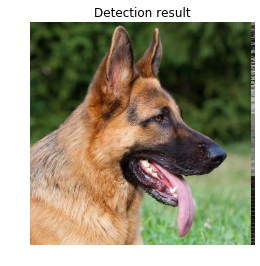

######################
    time -> method = recognition_url
13.1470019817
######################


In [43]:
recognition_url()